# `Conv1d`와 다른 점
- `shuffle`
- 4d 구조 변경 : 이미지 아니고 시계열이기 때문에, channel=1로 본다.
- kernel 2차원으로 움직인다.
- 강사님 함수 수정: step, feature, channel 인자 추가


In [1]:
# module import
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [4]:
# data 생성
def createData(X_data, step, feature, channel):
    m = np.arange(len(X_data)-step)
    np.random.shuffle(m) # shuffle 왜?

    x, y = [], []
    for i in m:
        a = X_data[i:i+step]
        b = X_data[i+1:i+1+step]
        x.append(a)
        y.append(b[-1])
    
    X = np.reshape(np.array(x), (len(m), step, feature, channel)) # conv1d에서는 원래 3차원
    Y = np.reshape(np.array(y), (len(m), 1))

    return X, Y

In [5]:
# 시계열 Sine 데이터 생성
n_step = int(input('스텝 설정: '))
n_feature = 1
n_channel = 1
data = np.sin(2*np.pi*0.03*np.arange(1001)) + np.random.random(1001) + np.arange(1001)*0.03
X_data, y_data = createData(data, n_step, n_feature, n_channel)
print(f"X: {X_data.shape}, y: {y_data.shape}")

스텝 설정: 20
X: (981, 20, 1, 1), y: (981, 1)


## 모델 구성 달라진 부분 잘 보기

In [6]:
# conv2d CNN 모델 구성
X_input = Input(batch_shape=(None, n_step, n_feature, n_channel))
X_conv_1 = Conv2D(filters=30, kernel_size=(8, 1), strides=1, padding='same', activation='relu')(X_input)
X_pool_1 = MaxPooling2D(pool_size=(2, 1), strides=1, padding='valid')(X_conv_1)
X_conv_2 = Conv2D(filters=10, kernel_size=(8, 1), strides=1, padding='same', activation='relu')(X_pool_1)
X_pool_2 = MaxPooling2D(pool_size=(2, 1), strides=1, padding='valid')(X_conv_2)
X_flat = Flatten()(X_pool_2)
X_output = Dense(1, activation='linear')(X_flat)

model = Model(X_input, X_output)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 1, 1)]        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 1, 30)         270       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 1, 30)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 1, 10)         2410      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 1, 10)         0         
_________________________________________________________________
flatten (Flatten)            (None, 180)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 181   

In [7]:
# 모델 학습
hist = model.fit(X_data, y_data,
                 epochs=100,
                 batch_size=300)

Epoch 1/100
4/4 [==============================] - 0s 14ms/step - loss: 58.8294
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 7.4425
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 13.0199
Epoch 4/100
4/4 [==============================] - 0s 11ms/step - loss: 1.2145
Epoch 5/100
4/4 [==============================] - 0s 11ms/step - loss: 4.5457
Epoch 6/100
4/4 [==============================] - 0s 11ms/step - loss: 2.9083
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 0.9753
Epoch 8/100
4/4 [==============================] - 0s 11ms/step - loss: 1.9526
Epoch 9/100
4/4 [==============================] - 0s 11ms/step - loss: 0.9412
Epoch 10/100
4/4 [==============================] - 0s 10ms/step - loss: 1.0074
Epoch 11/100
4/4 [==============================] - 0s 10ms/step - loss: 1.0378
Epoch 12/100
4/4 [==============================] - 0s 10ms/step - loss: 0.7480
Epoch 13/100
4/4 [=============================

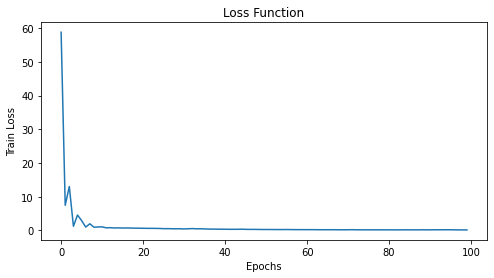

In [8]:
# plot loss
plt.figure(figsize=(8, 4))
plt.plot(hist.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('Loss Function')
plt.show()

In [9]:
# 예측
n_future = 20

last_data = np.copy(data[-100:])
X_pred = np.copy(last_data)
estimate = [X_pred[-1]]
print(X_pred.shape)

(100,)


In [12]:
for _ in range(n_future):
    x = X_pred[-n_step:].reshape(-1, n_step, n_feature, n_channel)
    y_hat = model.predict(x)[0][0]
    estimate.append(y_hat)
    X_pred = np.insert(X_pred, len(X_pred), y_hat)

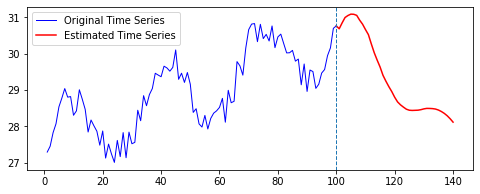

In [13]:
# plot 예측
ax1 = np.arange(1, len(last_data)+1)
ax2 = np.arange(len(last_data), len(last_data)+len(estimate))
plt.figure(figsize=(8, 3))
plt.plot(ax1, last_data, markersize=3, color='blue', label='Original Time Series', linewidth=1)
plt.plot(ax2, estimate, markersize=3, color='red', label='Estimated Time Series')
plt.axvline(ax1[-1], linestyle='dashed', linewidth=1)
plt.legend()
plt.show()